In [39]:
from scipy.io import loadmat
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchsummary import summary
from tqdm import tqdm
import numpy as np
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score, r2_score, confusion_matrix
from prettytable import PrettyTable
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit
%matplotlib inline
plt.rcParams['figure.figsize'] = (9,6)
# To ignore warnings
import warnings
warnings.filterwarnings('ignore')


# Reading and Defining Data

In [40]:
dataset_path="dataset"

In [41]:
import os
databases=os.listdir(dataset_path)

In [42]:
matrix_paths=[]
for db in databases:
    DB_PATH="/".join((dataset_path,db))
    for mat in os.listdir(DB_PATH):
        matrix_paths.append("/".join((DB_PATH,mat)))
for p in matrix_paths:
    print(p)

dataset/Database 2/male_day_1.mat
dataset/Database 2/male_day_2.mat
dataset/Database 2/male_day_3.mat


In [43]:
data=[]
features=['cyl_ch1', 'cyl_ch2', 'hook_ch1', 'hook_ch2', 'tip_ch1', 'tip_ch2', 'palm_ch1', 'palm_ch2', 'spher_ch1', 'spher_ch2', 'lat_ch1', 'lat_ch2']
label_dict={
    'cyl_ch1':0, 'cyl_ch2':0,
    'hook_ch1':1, 'hook_ch2':1, 
    'tip_ch1':2, 'tip_ch2':2, 
    'palm_ch1':3, 'palm_ch2':3,
    'spher_ch1':4, 'spher_ch2':4, 
    'lat_ch1':5, 'lat_ch2':5
}

In [44]:
for path in matrix_paths:
    loaded_mat=loadmat(path)
    for k in loaded_mat.keys():
        if k in label_dict.keys():
            for row in loaded_mat[k]:
                row= np.append(row,[int(label_dict[k])],axis=0)
                data.append(row)

In [45]:
col=np.append(np.arange(1, 2501).astype(str), "Class")
df=pd.DataFrame(data,columns=col)
df["Class"]=df["Class"].astype(int)

# Some Cells to Understand Data

In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3600 entries, 0 to 3599
Columns: 2501 entries, 1 to Class
dtypes: float64(2500), int32(1)
memory usage: 68.7 MB


In [47]:
# Check if there are any Duplicate values
df.duplicated().any()

False

<Axes: xlabel='Class', ylabel='count'>

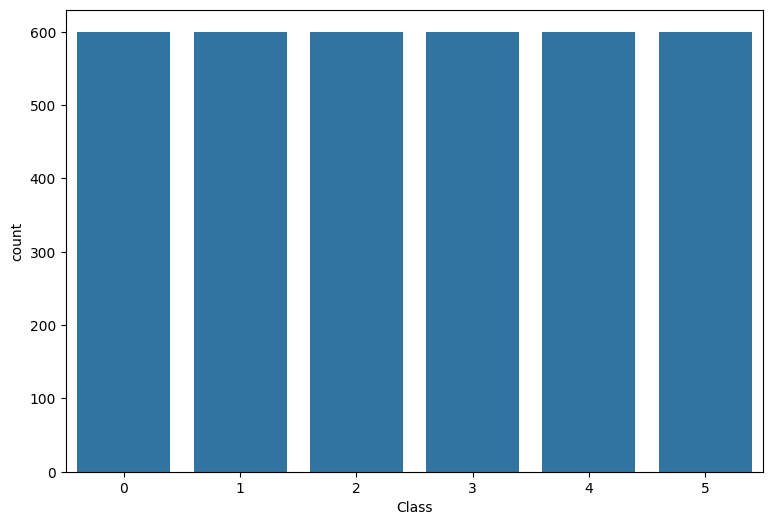

In [48]:
sns.countplot(x='Class',data=df)

# Dataset and Model

In [49]:
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [50]:
class DeepModel(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size, dropout_prob=0.2):
        super(DeepModel, self).__init__()
        layers = []
        for i in range(len(hidden_sizes)):
            if i == 0:
                layers.append(nn.Linear(input_size, hidden_sizes[i]))
            else:
                layers.append(nn.Linear(hidden_sizes[i-1], hidden_sizes[i]))
            layers.append(nn.ReLU())
            if (i+1) % 2 == 0:
                layers.append(nn.Dropout(p=dropout_prob))
        layers.append(nn.Linear(hidden_sizes[-1], output_size))
        self.model = nn.Sequential(*layers)
        self.initialize_weights()
        
    def forward(self, x):
        return self.model(x)
    
    def initialize_weights(self):
        for layer in self.model:
            if isinstance(layer, nn.Linear):
                init.xavier_uniform_(layer.weight)
                init.constant_(layer.bias, 0)

# Splitting data as X and y

In [51]:
X=df.drop(["Class"],axis=1).to_numpy()
y=df["Class"].to_numpy()

In [52]:
# from sklearn.model_selection import train_test_split

# # Elimizdeki veri setini X ve y olarak ayırın
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
# X_train=X_train.to_numpy()
# X_test=X_test.to_numpy()
# y_train=y_train.to_numpy()
# y_test=y_test.to_numpy()

# # CustomDataset sınıfını kullanarak DataLoader'ları oluşturun
# train_dataset = CustomDataset(X_train, y_train)
# test_dataset = CustomDataset(X_test, y_test)

# # DataLoader'ları ayarlayın
# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [53]:
# Parameters
input_size = 2500
hidden_sizes = [256,128,64,64] 
output_size = 6
best_loss = np.inf

In [54]:
model = DeepModel(input_size, hidden_sizes, output_size)
criterion = nn.CrossEntropyLoss()   #Loss function  
optimizer = optim.Adam(model.parameters(),lr=0.0001)    #Optimizer

In [55]:
summary(model, (input_size,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 256]         640,256
              ReLU-2                  [-1, 256]               0
            Linear-3                  [-1, 128]          32,896
              ReLU-4                  [-1, 128]               0
           Dropout-5                  [-1, 128]               0
            Linear-6                   [-1, 64]           8,256
              ReLU-7                   [-1, 64]               0
            Linear-8                   [-1, 64]           4,160
              ReLU-9                   [-1, 64]               0
          Dropout-10                   [-1, 64]               0
           Linear-11                    [-1, 6]             390
Total params: 685,958
Trainable params: 685,958
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/

In [56]:
def train(model, train_loader, criterion, optimizer, epoch, lasso_lambda=0.0, ridge_lambda=0.0):
    # Set the model to training mode
    model.train()
    
    # Initialize variables to track the running loss, correct predictions, and total samples
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    
    # Iterate over the training data
    for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch + 1}/Training'):
        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
    
        # Compute the data loss using the specified criterion
        loss = criterion(outputs, labels.type(torch.LongTensor))

        # Compute L1 regularization loss (Lasso) and add it to the total loss
        l1_loss = sum(lasso_lambda * torch.sum(torch.abs(param)) for param in model.parameters())

        # Compute L2 regularization loss (Ridge) and add it to the total loss
        l2_loss = sum(ridge_lambda * torch.sum(torch.square(param)) for param in model.parameters())

        # Combine regularization loss with the data loss
        total_loss = loss + l1_loss + l2_loss

        # Backward pass
        total_loss.backward()

        # Update the model parameters
        optimizer.step()

        # Update the running loss
        running_loss += loss.item()

        # Calculate the number of correct predictions and total samples
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_samples += labels.size(0)
    
    # Calculate average loss and accuracy
    average_loss = running_loss / len(train_loader)
    accuracy = correct_predictions / total_samples

    return average_loss, accuracy

def evaluate(model, test_loader, criterion, epoch):
    # Set the model to evaluation mode
    model.eval()
    
    # Initialize variables for accuracy and loss
    correct = 0
    total = 0
    running_loss = 0.0
    
    # Lists to store predictions and labels for additional metrics
    all_predictions = []
    all_labels = []
    
    # Disable gradient computation during evaluation
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc=f'Epoch {epoch + 1}/Testing'):
            # Forward pass
            outputs = model(inputs)
            
            # Compute the loss using the specified criterion
            loss = criterion(outputs, labels.type(torch.LongTensor))
            running_loss += loss.item()
            
            # Calculate the number of correct predictions
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Store predictions and labels for additional metrics
            all_predictions.extend(predicted.numpy())
            all_labels.extend(labels.numpy())

    # Calculate average loss and accuracy
    average_loss = running_loss / len(test_loader)
    accuracy = correct / total
    
    # Calculate additional evaluation metrics
    precision = precision_score(all_labels, all_predictions, average="macro")
    recall = recall_score(all_labels, all_predictions, average="macro")
    f1 = f1_score(all_labels, all_predictions, average="macro")
    r2 = r2_score(all_labels, all_predictions)

    # Visualize confusion matrix every 5 epochs
    if (epoch+1) % 4 == 0:
        cm = confusion_matrix(all_labels, all_predictions)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm', xticklabels=["Cycle","Hook","Tip","Palm","Spher","Lat"], yticklabels=["Cycle","Hook","Tip","Palm","Spher","Lat"],
                    annot_kws={"color": 'black', "weight": 'bold', 'size': 18})
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix')

        plt.show()

    return average_loss, accuracy, precision, recall, f1, r2


Epoch 1/Testing: 100%|██████████| 90/90 [00:00<00:00, 891.07it/s]


+------------+------------+-----------+-----------+-----------+--------+----------+----------+
| Train Loss | Train Acc. | Test Loss | Test Acc. | Precision | Recall | F1 Score | R2 Score |
+------------+------------+-----------+-----------+-----------+--------+----------+----------+
|   1.8491   |   18.98%   |   1.7737  |   20.35%  |   0.1868  | 0.2035 |  0.1581  | -0.8021  |
+------------+------------+-----------+-----------+-----------+--------+----------+----------+
****************************************************************************************************


Epoch 2/Testing: 100%|██████████| 90/90 [00:00<00:00, 625.00it/s]


+------------+------------+-----------+-----------+-----------+--------+----------+----------+
| Train Loss | Train Acc. | Test Loss | Test Acc. | Precision | Recall | F1 Score | R2 Score |
+------------+------------+-----------+-----------+-----------+--------+----------+----------+
|   1.6979   |   27.41%   |   1.7312  |   22.57%  |   0.2109  | 0.2257 |  0.1972  | -0.5995  |
+------------+------------+-----------+-----------+-----------+--------+----------+----------+
****************************************************************************************************


Epoch 3/Testing: 100%|██████████| 90/90 [00:00<00:00, 882.37it/s]


+------------+------------+-----------+-----------+-----------+--------+----------+----------+
| Train Loss | Train Acc. | Test Loss | Test Acc. | Precision | Recall | F1 Score | R2 Score |
+------------+------------+-----------+-----------+-----------+--------+----------+----------+
|   1.5798   |   35.65%   |   1.7052  |   23.68%  |   0.2174  | 0.2368 |  0.1995  | -0.7310  |
+------------+------------+-----------+-----------+-----------+--------+----------+----------+
****************************************************************************************************


Epoch 4/Testing: 100%|██████████| 90/90 [00:00<00:00, 502.79it/s]


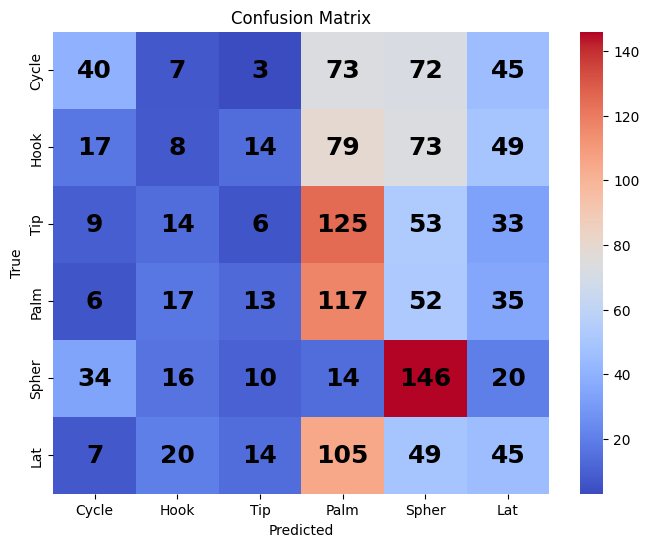

+------------+------------+-----------+-----------+-----------+--------+----------+----------+
| Train Loss | Train Acc. | Test Loss | Test Acc. | Precision | Recall | F1 Score | R2 Score |
+------------+------------+-----------+-----------+-----------+--------+----------+----------+
|   1.4830   |   39.31%   |   1.6958  |   25.14%  |   0.2177  | 0.2514 |  0.2077  | -0.8105  |
+------------+------------+-----------+-----------+-----------+--------+----------+----------+
****************************************************************************************************


Epoch 5/Testing: 100%|██████████| 90/90 [00:00<00:00, 452.26it/s]


+------------+------------+-----------+-----------+-----------+--------+----------+----------+
| Train Loss | Train Acc. | Test Loss | Test Acc. | Precision | Recall | F1 Score | R2 Score |
+------------+------------+-----------+-----------+-----------+--------+----------+----------+
|   1.3647   |   47.78%   |   1.7066  |   25.21%  |   0.2174  | 0.2521 |  0.1961  | -0.5893  |
+------------+------------+-----------+-----------+-----------+--------+----------+----------+
****************************************************************************************************


Epoch 6/Testing: 100%|██████████| 90/90 [00:00<00:00, 661.77it/s]


+------------+------------+-----------+-----------+-----------+--------+----------+----------+
| Train Loss | Train Acc. | Test Loss | Test Acc. | Precision | Recall | F1 Score | R2 Score |
+------------+------------+-----------+-----------+-----------+--------+----------+----------+
|   1.2501   |   52.73%   |   1.7426  |   26.32%  |   0.2642  | 0.2632 |  0.2337  | -0.8052  |
+------------+------------+-----------+-----------+-----------+--------+----------+----------+
****************************************************************************************************


Epoch 7/Testing: 100%|██████████| 90/90 [00:00<00:00, 542.17it/s]


+------------+------------+-----------+-----------+-----------+--------+----------+----------+
| Train Loss | Train Acc. | Test Loss | Test Acc. | Precision | Recall | F1 Score | R2 Score |
+------------+------------+-----------+-----------+-----------+--------+----------+----------+
|   1.1412   |   57.96%   |   1.7731  |   24.79%  |   0.2435  | 0.2479 |  0.2315  | -0.7162  |
+------------+------------+-----------+-----------+-----------+--------+----------+----------+
****************************************************************************************************


Epoch 8/Testing: 100%|██████████| 90/90 [00:00<00:00, 708.64it/s]


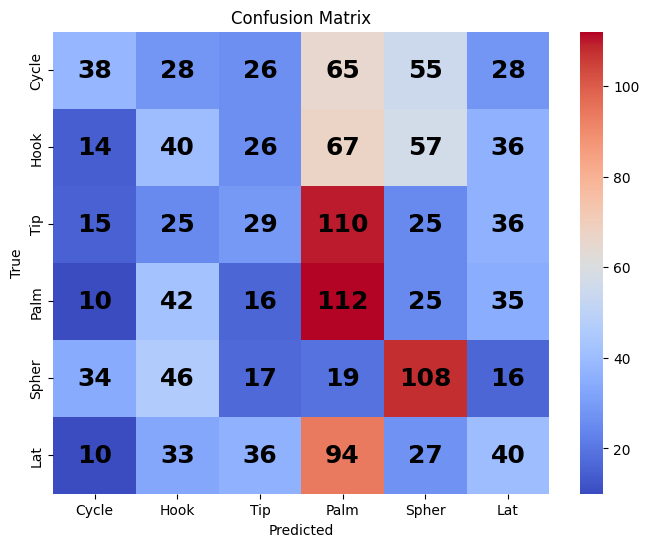

+------------+------------+-----------+-----------+-----------+--------+----------+----------+
| Train Loss | Train Acc. | Test Loss | Test Acc. | Precision | Recall | F1 Score | R2 Score |
+------------+------------+-----------+-----------+-----------+--------+----------+----------+
|   1.0250   |   62.78%   |   1.8406  |   25.49%  |   0.2512  | 0.2549 |  0.2400  | -0.7424  |
+------------+------------+-----------+-----------+-----------+--------+----------+----------+
****************************************************************************************************


Epoch 9/Testing: 100%|██████████| 90/90 [00:00<00:00, 1011.24it/s]


+------------+------------+-----------+-----------+-----------+--------+----------+----------+
| Train Loss | Train Acc. | Test Loss | Test Acc. | Precision | Recall | F1 Score | R2 Score |
+------------+------------+-----------+-----------+-----------+--------+----------+----------+
|   1.3240   |   50.28%   |   1.2328  |   55.28%  |   0.5954  | 0.5528 |  0.5503  |  0.1210  |
+------------+------------+-----------+-----------+-----------+--------+----------+----------+
****************************************************************************************************


Epoch 10/Testing: 100%|██████████| 90/90 [00:00<00:00, 782.61it/s]


+------------+------------+-----------+-----------+-----------+--------+----------+----------+
| Train Loss | Train Acc. | Test Loss | Test Acc. | Precision | Recall | F1 Score | R2 Score |
+------------+------------+-----------+-----------+-----------+--------+----------+----------+
|   1.1128   |   57.82%   |   1.2278  |   53.68%  |   0.5929  | 0.5368 |  0.5346  |  0.0243  |
+------------+------------+-----------+-----------+-----------+--------+----------+----------+
****************************************************************************************************


Epoch 11/Testing: 100%|██████████| 90/90 [00:00<00:00, 476.19it/s]


+------------+------------+-----------+-----------+-----------+--------+----------+----------+
| Train Loss | Train Acc. | Test Loss | Test Acc. | Precision | Recall | F1 Score | R2 Score |
+------------+------------+-----------+-----------+-----------+--------+----------+----------+
|   0.9466   |   66.06%   |   1.2382  |   54.72%  |   0.5864  | 0.5472 |  0.5461  | -0.3000  |
+------------+------------+-----------+-----------+-----------+--------+----------+----------+
****************************************************************************************************


Epoch 12/Testing: 100%|██████████| 90/90 [00:00<00:00, 559.67it/s]


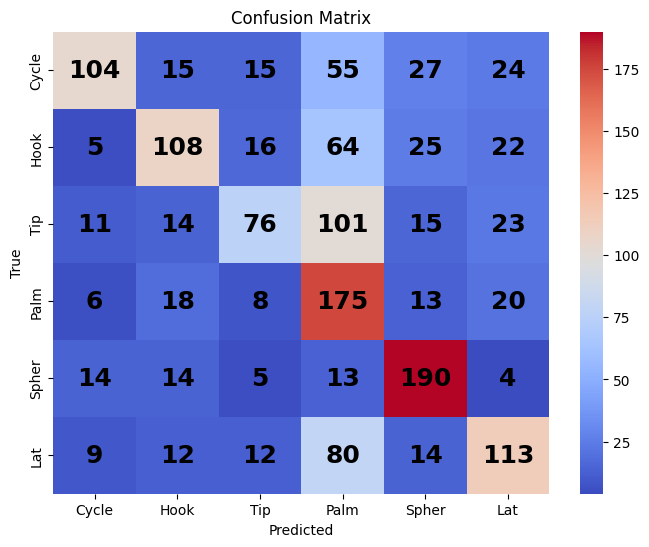

+------------+------------+-----------+-----------+-----------+--------+----------+----------+
| Train Loss | Train Acc. | Test Loss | Test Acc. | Precision | Recall | F1 Score | R2 Score |
+------------+------------+-----------+-----------+-----------+--------+----------+----------+
|   0.8356   |   71.02%   |   1.2715  |   53.19%  |   0.5744  | 0.5319 |  0.5282  | -0.0369  |
+------------+------------+-----------+-----------+-----------+--------+----------+----------+
****************************************************************************************************


Epoch 13/Testing: 100%|██████████| 90/90 [00:00<00:00, 789.48it/s]


+------------+------------+-----------+-----------+-----------+--------+----------+----------+
| Train Loss | Train Acc. | Test Loss | Test Acc. | Precision | Recall | F1 Score | R2 Score |
+------------+------------+-----------+-----------+-----------+--------+----------+----------+
|   0.7277   |   74.77%   |   1.3158  |   54.44%  |   0.5581  | 0.5444 |  0.5413  | -0.2083  |
+------------+------------+-----------+-----------+-----------+--------+----------+----------+
****************************************************************************************************


Epoch 14/Testing: 100%|██████████| 90/90 [00:00<00:00, 849.04it/s]


+------------+------------+-----------+-----------+-----------+--------+----------+----------+
| Train Loss | Train Acc. | Test Loss | Test Acc. | Precision | Recall | F1 Score | R2 Score |
+------------+------------+-----------+-----------+-----------+--------+----------+----------+
|   0.6278   |   79.49%   |   1.4511  |   50.21%  |   0.5683  | 0.5021 |  0.4890  | -0.0355  |
+------------+------------+-----------+-----------+-----------+--------+----------+----------+
****************************************************************************************************


Epoch 15/Testing: 100%|██████████| 90/90 [00:00<00:00, 629.37it/s]


+------------+------------+-----------+-----------+-----------+--------+----------+----------+
| Train Loss | Train Acc. | Test Loss | Test Acc. | Precision | Recall | F1 Score | R2 Score |
+------------+------------+-----------+-----------+-----------+--------+----------+----------+
|   0.5608   |   80.83%   |   1.4191  |   52.36%  |   0.5368  | 0.5236 |  0.5227  | -0.2600  |
+------------+------------+-----------+-----------+-----------+--------+----------+----------+
****************************************************************************************************


Epoch 16/Testing: 100%|██████████| 90/90 [00:00<00:00, 849.06it/s]


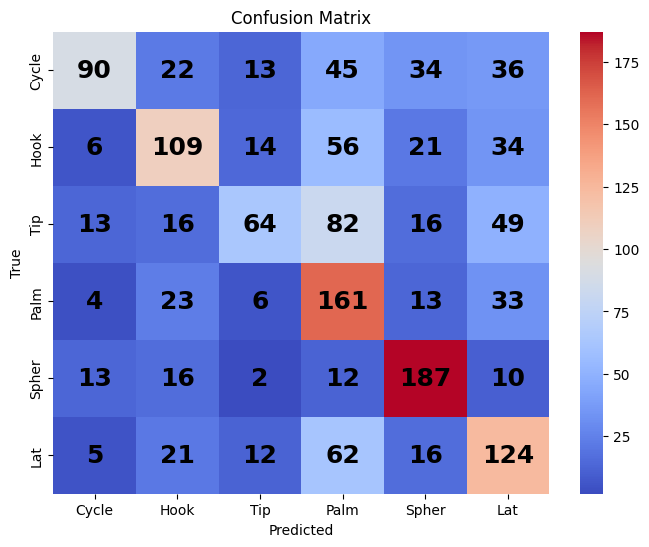

+------------+------------+-----------+-----------+-----------+--------+----------+----------+
| Train Loss | Train Acc. | Test Loss | Test Acc. | Precision | Recall | F1 Score | R2 Score |
+------------+------------+-----------+-----------+-----------+--------+----------+----------+
|   0.4605   |   85.28%   |   1.5560  |   51.04%  |   0.5434  | 0.5104 |  0.5013  | -0.2021  |
+------------+------------+-----------+-----------+-----------+--------+----------+----------+
****************************************************************************************************


Epoch 17/Testing: 100%|██████████| 90/90 [00:00<00:00, 947.37it/s]


+------------+------------+-----------+-----------+-----------+--------+----------+----------+
| Train Loss | Train Acc. | Test Loss | Test Acc. | Precision | Recall | F1 Score | R2 Score |
+------------+------------+-----------+-----------+-----------+--------+----------+----------+
|   0.9412   |   69.68%   |   0.7758  |   74.10%  |   0.7824  | 0.7410 |  0.7461  |  0.4840  |
+------------+------------+-----------+-----------+-----------+--------+----------+----------+
****************************************************************************************************


Epoch 18/Testing: 100%|██████████| 90/90 [00:00<00:00, 865.37it/s]


+------------+------------+-----------+-----------+-----------+--------+----------+----------+
| Train Loss | Train Acc. | Test Loss | Test Acc. | Precision | Recall | F1 Score | R2 Score |
+------------+------------+-----------+-----------+-----------+--------+----------+----------+
|   0.6470   |   78.89%   |   0.7524  |   75.97%  |   0.7795  | 0.7597 |  0.7620  |  0.4238  |
+------------+------------+-----------+-----------+-----------+--------+----------+----------+
****************************************************************************************************


Epoch 19/Testing: 100%|██████████| 90/90 [00:00<00:00, 857.15it/s]


+------------+------------+-----------+-----------+-----------+--------+----------+----------+
| Train Loss | Train Acc. | Test Loss | Test Acc. | Precision | Recall | F1 Score | R2 Score |
+------------+------------+-----------+-----------+-----------+--------+----------+----------+
|   0.5140   |   83.06%   |   0.7839  |   75.14%  |   0.7772  | 0.7514 |  0.7528  |  0.4469  |
+------------+------------+-----------+-----------+-----------+--------+----------+----------+
****************************************************************************************************


Epoch 20/Testing: 100%|██████████| 90/90 [00:00<00:00, 756.30it/s]


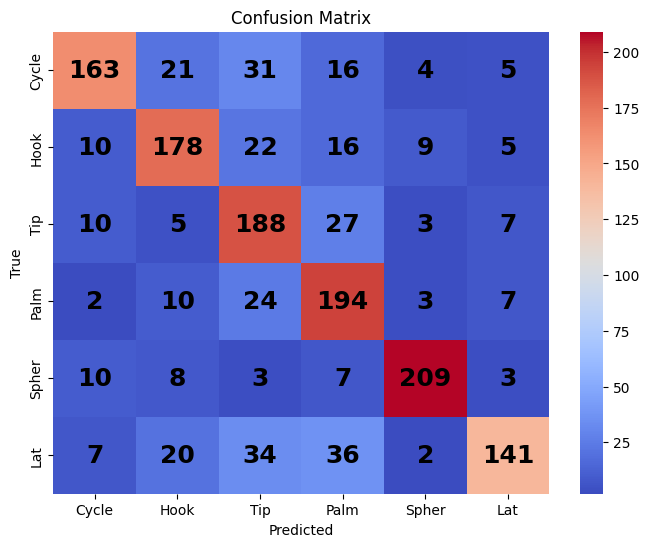

+------------+------------+-----------+-----------+-----------+--------+----------+----------+
| Train Loss | Train Acc. | Test Loss | Test Acc. | Precision | Recall | F1 Score | R2 Score |
+------------+------------+-----------+-----------+-----------+--------+----------+----------+
|   0.4114   |   86.67%   |   0.7806  |   74.51%  |   0.7614  | 0.7451 |  0.7457  |  0.4771  |
+------------+------------+-----------+-----------+-----------+--------+----------+----------+
****************************************************************************************************


Epoch 21/Testing: 100%|██████████| 90/90 [00:00<00:00, 900.00it/s]


+------------+------------+-----------+-----------+-----------+--------+----------+----------+
| Train Loss | Train Acc. | Test Loss | Test Acc. | Precision | Recall | F1 Score | R2 Score |
+------------+------------+-----------+-----------+-----------+--------+----------+----------+
|   0.3566   |   88.80%   |   0.7987  |   74.86%  |   0.7589  | 0.7486 |  0.7485  |  0.4557  |
+------------+------------+-----------+-----------+-----------+--------+----------+----------+
****************************************************************************************************


Epoch 22/Testing: 100%|██████████| 90/90 [00:00<00:00, 743.81it/s]


+------------+------------+-----------+-----------+-----------+--------+----------+----------+
| Train Loss | Train Acc. | Test Loss | Test Acc. | Precision | Recall | F1 Score | R2 Score |
+------------+------------+-----------+-----------+-----------+--------+----------+----------+
|   0.2867   |   91.85%   |   0.8623  |   72.99%  |   0.7546  | 0.7299 |  0.7311  |  0.4302  |
+------------+------------+-----------+-----------+-----------+--------+----------+----------+
****************************************************************************************************


Epoch 23/Testing: 100%|██████████| 90/90 [00:00<00:00, 737.70it/s]


+------------+------------+-----------+-----------+-----------+--------+----------+----------+
| Train Loss | Train Acc. | Test Loss | Test Acc. | Precision | Recall | F1 Score | R2 Score |
+------------+------------+-----------+-----------+-----------+--------+----------+----------+
|   0.2597   |   92.73%   |   0.9230  |   72.22%  |   0.7545  | 0.7222 |  0.7236  |  0.4062  |
+------------+------------+-----------+-----------+-----------+--------+----------+----------+
****************************************************************************************************


Epoch 24/Testing: 100%|██████████| 90/90 [00:00<00:00, 882.35it/s]


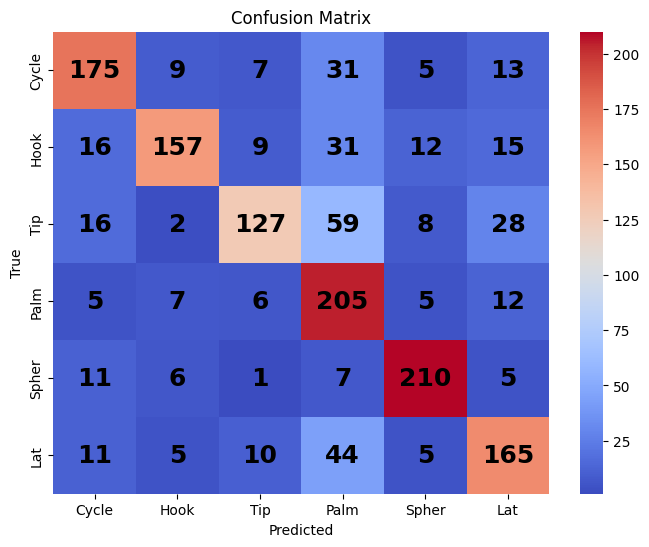

+------------+------------+-----------+-----------+-----------+--------+----------+----------+
| Train Loss | Train Acc. | Test Loss | Test Acc. | Precision | Recall | F1 Score | R2 Score |
+------------+------------+-----------+-----------+-----------+--------+----------+----------+
|   0.2031   |   94.95%   |   0.9482  |   72.15%  |   0.7466  | 0.7215 |  0.7219  |  0.3736  |
+------------+------------+-----------+-----------+-----------+--------+----------+----------+
****************************************************************************************************


Epoch 25/Testing: 100%|██████████| 90/90 [00:00<00:00, 661.77it/s]


+------------+------------+-----------+-----------+-----------+--------+----------+----------+
| Train Loss | Train Acc. | Test Loss | Test Acc. | Precision | Recall | F1 Score | R2 Score |
+------------+------------+-----------+-----------+-----------+--------+----------+----------+
|   0.5288   |   84.63%   |   0.4246  |   89.79%  |   0.8991  | 0.8979 |  0.8979  |  0.7705  |
+------------+------------+-----------+-----------+-----------+--------+----------+----------+
****************************************************************************************************


Epoch 26/Testing: 100%|██████████| 90/90 [00:00<00:00, 775.85it/s]


+------------+------------+-----------+-----------+-----------+--------+----------+----------+
| Train Loss | Train Acc. | Test Loss | Test Acc. | Precision | Recall | F1 Score | R2 Score |
+------------+------------+-----------+-----------+-----------+--------+----------+----------+
|   0.3272   |   90.00%   |   0.4356  |   88.75%  |   0.8901  | 0.8875 |  0.8876  |  0.7281  |
+------------+------------+-----------+-----------+-----------+--------+----------+----------+
****************************************************************************************************


Epoch 27/Testing: 100%|██████████| 90/90 [00:00<00:00, 511.36it/s]


+------------+------------+-----------+-----------+-----------+--------+----------+----------+
| Train Loss | Train Acc. | Test Loss | Test Acc. | Precision | Recall | F1 Score | R2 Score |
+------------+------------+-----------+-----------+-----------+--------+----------+----------+
|   0.2513   |   92.64%   |   0.4585  |   86.94%  |   0.8771  | 0.8694 |  0.8704  |  0.6462  |
+------------+------------+-----------+-----------+-----------+--------+----------+----------+
****************************************************************************************************


Epoch 28/Testing: 100%|██████████| 90/90 [00:00<00:00, 714.28it/s]


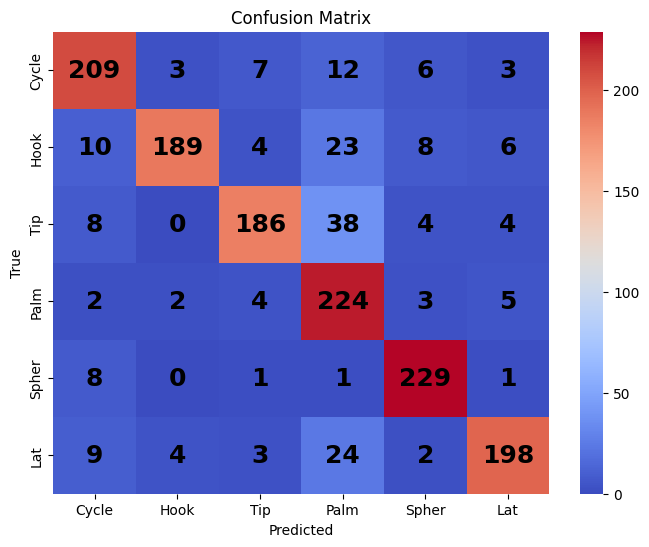

+------------+------------+-----------+-----------+-----------+--------+----------+----------+
| Train Loss | Train Acc. | Test Loss | Test Acc. | Precision | Recall | F1 Score | R2 Score |
+------------+------------+-----------+-----------+-----------+--------+----------+----------+
|   0.1911   |   95.23%   |   0.5120  |   85.76%  |   0.8714  | 0.8576 |  0.8589  |  0.6888  |
+------------+------------+-----------+-----------+-----------+--------+----------+----------+
****************************************************************************************************


Epoch 29/Testing: 100%|██████████| 90/90 [00:00<00:00, 967.74it/s]


+------------+------------+-----------+-----------+-----------+--------+----------+----------+
| Train Loss | Train Acc. | Test Loss | Test Acc. | Precision | Recall | F1 Score | R2 Score |
+------------+------------+-----------+-----------+-----------+--------+----------+----------+
|   0.1722   |   95.65%   |   0.4715  |   87.85%  |   0.8809  | 0.8785 |  0.8785  |  0.7198  |
+------------+------------+-----------+-----------+-----------+--------+----------+----------+
****************************************************************************************************


Epoch 30/Testing: 100%|██████████| 90/90 [00:00<00:00, 407.24it/s]


+------------+------------+-----------+-----------+-----------+--------+----------+----------+
| Train Loss | Train Acc. | Test Loss | Test Acc. | Precision | Recall | F1 Score | R2 Score |
+------------+------------+-----------+-----------+-----------+--------+----------+----------+
|   0.1332   |   97.18%   |   0.4966  |   87.64%  |   0.8791  | 0.8764 |  0.8763  |  0.7071  |
+------------+------------+-----------+-----------+-----------+--------+----------+----------+
****************************************************************************************************


Epoch 31/Testing: 100%|██████████| 90/90 [00:00<00:00, 857.14it/s]


+------------+------------+-----------+-----------+-----------+--------+----------+----------+
| Train Loss | Train Acc. | Test Loss | Test Acc. | Precision | Recall | F1 Score | R2 Score |
+------------+------------+-----------+-----------+-----------+--------+----------+----------+
|   0.1056   |   97.73%   |   0.5625  |   84.72%  |   0.8647  | 0.8472 |  0.8497  |  0.7031  |
+------------+------------+-----------+-----------+-----------+--------+----------+----------+
****************************************************************************************************


Epoch 32/Testing: 100%|██████████| 90/90 [00:00<00:00, 679.14it/s]


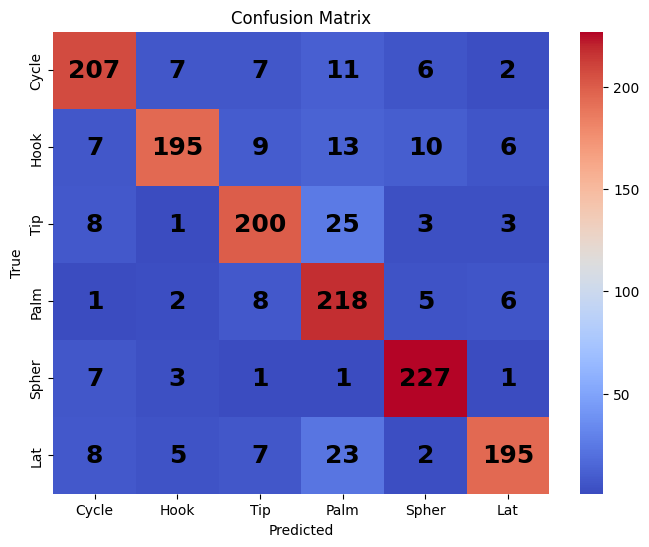

+------------+------------+-----------+-----------+-----------+--------+----------+----------+
| Train Loss | Train Acc. | Test Loss | Test Acc. | Precision | Recall | F1 Score | R2 Score |
+------------+------------+-----------+-----------+-----------+--------+----------+----------+
|   0.1017   |   97.73%   |   0.5299  |   86.25%  |   0.8682  | 0.8625 |  0.8629  |  0.6983  |
+------------+------------+-----------+-----------+-----------+--------+----------+----------+
****************************************************************************************************


Epoch 33/Testing: 100%|██████████| 90/90 [00:00<00:00, 769.23it/s]


+------------+------------+-----------+-----------+-----------+--------+----------+----------+
| Train Loss | Train Acc. | Test Loss | Test Acc. | Precision | Recall | F1 Score | R2 Score |
+------------+------------+-----------+-----------+-----------+--------+----------+----------+
|   0.3159   |   91.71%   |   0.3816  |   87.71%  |   0.9095  | 0.8771 |  0.8819  |  0.8150  |
+------------+------------+-----------+-----------+-----------+--------+----------+----------+
****************************************************************************************************


Epoch 34/Testing: 100%|██████████| 90/90 [00:00<00:00, 731.71it/s]


+------------+------------+-----------+-----------+-----------+--------+----------+----------+
| Train Loss | Train Acc. | Test Loss | Test Acc. | Precision | Recall | F1 Score | R2 Score |
+------------+------------+-----------+-----------+-----------+--------+----------+----------+
|   0.1754   |   95.51%   |   0.3301  |   90.35%  |   0.9181  | 0.9035 |  0.9048  |  0.8260  |
+------------+------------+-----------+-----------+-----------+--------+----------+----------+
****************************************************************************************************


Epoch 35/Testing: 100%|██████████| 90/90 [00:00<00:00, 552.16it/s]


+------------+------------+-----------+-----------+-----------+--------+----------+----------+
| Train Loss | Train Acc. | Test Loss | Test Acc. | Precision | Recall | F1 Score | R2 Score |
+------------+------------+-----------+-----------+-----------+--------+----------+----------+
|   0.1363   |   96.53%   |   0.2625  |   93.40%  |   0.9361  | 0.9340 |  0.9342  |  0.8510  |
+------------+------------+-----------+-----------+-----------+--------+----------+----------+
****************************************************************************************************


Epoch 36/Testing: 100%|██████████| 90/90 [00:00<00:00, 618.45it/s]


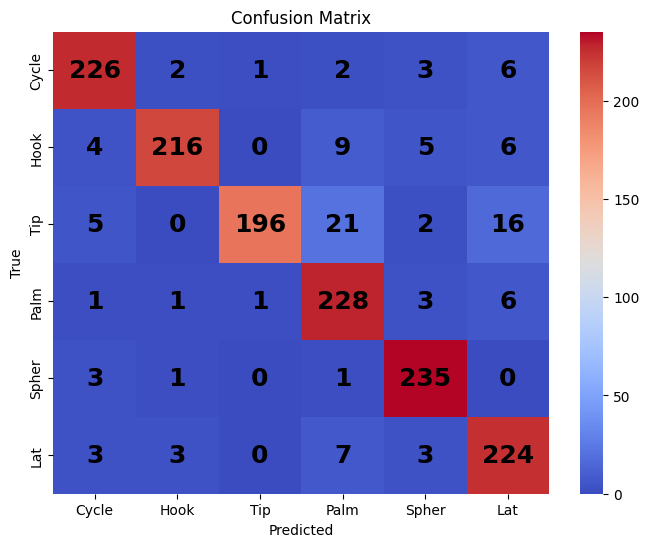

+------------+------------+-----------+-----------+-----------+--------+----------+----------+
| Train Loss | Train Acc. | Test Loss | Test Acc. | Precision | Recall | F1 Score | R2 Score |
+------------+------------+-----------+-----------+-----------+--------+----------+----------+
|   0.0948   |   97.78%   |   0.2978  |   92.01%  |   0.9246  | 0.9201 |  0.9200  |  0.7979  |
+------------+------------+-----------+-----------+-----------+--------+----------+----------+
****************************************************************************************************


Epoch 37/Testing: 100%|██████████| 90/90 [00:00<00:00, 486.49it/s]


+------------+------------+-----------+-----------+-----------+--------+----------+----------+
| Train Loss | Train Acc. | Test Loss | Test Acc. | Precision | Recall | F1 Score | R2 Score |
+------------+------------+-----------+-----------+-----------+--------+----------+----------+
|   0.0853   |   97.87%   |   0.2882  |   92.43%  |   0.9285  | 0.9243 |  0.9239  |  0.8560  |
+------------+------------+-----------+-----------+-----------+--------+----------+----------+
****************************************************************************************************


Epoch 38/Testing: 100%|██████████| 90/90 [00:00<00:00, 303.03it/s]


+------------+------------+-----------+-----------+-----------+--------+----------+----------+
| Train Loss | Train Acc. | Test Loss | Test Acc. | Precision | Recall | F1 Score | R2 Score |
+------------+------------+-----------+-----------+-----------+--------+----------+----------+
|   0.0601   |   98.98%   |   0.2764  |   92.85%  |   0.9321  | 0.9285 |  0.9286  |  0.8614  |
+------------+------------+-----------+-----------+-----------+--------+----------+----------+
****************************************************************************************************


Epoch 39/Testing: 100%|██████████| 90/90 [00:00<00:00, 535.67it/s]


+------------+------------+-----------+-----------+-----------+--------+----------+----------+
| Train Loss | Train Acc. | Test Loss | Test Acc. | Precision | Recall | F1 Score | R2 Score |
+------------+------------+-----------+-----------+-----------+--------+----------+----------+
|   0.0648   |   98.70%   |   0.2582  |   93.26%  |   0.9333  | 0.9326 |  0.9326  |  0.8517  |
+------------+------------+-----------+-----------+-----------+--------+----------+----------+
****************************************************************************************************


Epoch 40/Testing: 100%|██████████| 90/90 [00:00<00:00, 430.63it/s]


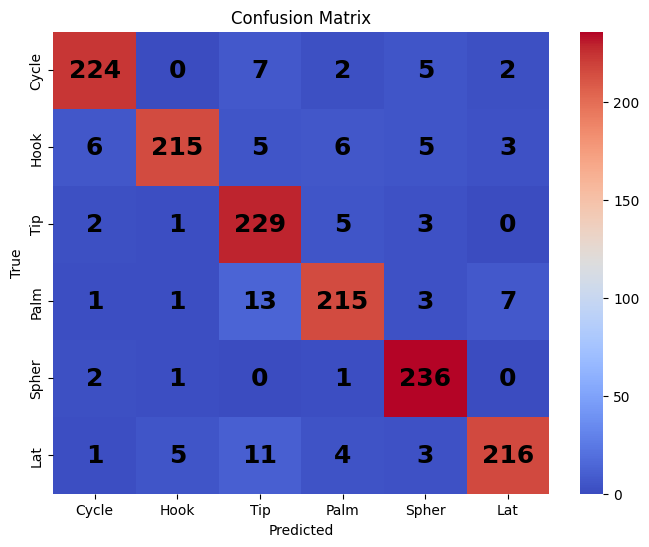

+------------+------------+-----------+-----------+-----------+--------+----------+----------+
| Train Loss | Train Acc. | Test Loss | Test Acc. | Precision | Recall | F1 Score | R2 Score |
+------------+------------+-----------+-----------+-----------+--------+----------+----------+
|   0.0458   |   99.07%   |   0.2755  |   92.71%  |   0.9288  | 0.9271 |  0.9271  |  0.8448  |
+------------+------------+-----------+-----------+-----------+--------+----------+----------+
****************************************************************************************************


Epoch 41/Testing: 100%|██████████| 90/90 [00:00<00:00, 542.17it/s]


+------------+------------+-----------+-----------+-----------+--------+----------+----------+
| Train Loss | Train Acc. | Test Loss | Test Acc. | Precision | Recall | F1 Score | R2 Score |
+------------+------------+-----------+-----------+-----------+--------+----------+----------+
|   0.1775   |   95.32%   |   0.1358  |   96.94%  |   0.9697  | 0.9694 |  0.9694  |  0.9243  |
+------------+------------+-----------+-----------+-----------+--------+----------+----------+
****************************************************************************************************


Epoch 42/Testing: 100%|██████████| 90/90 [00:00<00:00, 614.25it/s]


+------------+------------+-----------+-----------+-----------+--------+----------+----------+
| Train Loss | Train Acc. | Test Loss | Test Acc. | Precision | Recall | F1 Score | R2 Score |
+------------+------------+-----------+-----------+-----------+--------+----------+----------+
|   0.0895   |   98.01%   |   0.1459  |   96.46%  |   0.9655  | 0.9646 |  0.9647  |  0.9340  |
+------------+------------+-----------+-----------+-----------+--------+----------+----------+
****************************************************************************************************


Epoch 43/Testing: 100%|██████████| 90/90 [00:00<00:00, 620.68it/s]


+------------+------------+-----------+-----------+-----------+--------+----------+----------+
| Train Loss | Train Acc. | Test Loss | Test Acc. | Precision | Recall | F1 Score | R2 Score |
+------------+------------+-----------+-----------+-----------+--------+----------+----------+
|   0.0616   |   98.75%   |   0.1569  |   95.83%  |   0.9591  | 0.9583 |  0.9583  |  0.9121  |
+------------+------------+-----------+-----------+-----------+--------+----------+----------+
****************************************************************************************************


Epoch 44/Testing: 100%|██████████| 90/90 [00:00<00:00, 517.24it/s]


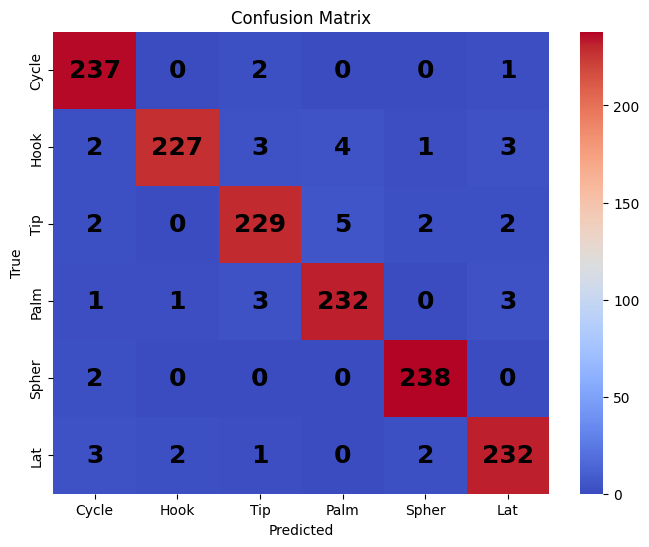

+------------+------------+-----------+-----------+-----------+--------+----------+----------+
| Train Loss | Train Acc. | Test Loss | Test Acc. | Precision | Recall | F1 Score | R2 Score |
+------------+------------+-----------+-----------+-----------+--------+----------+----------+
|   0.0473   |   98.89%   |   0.1355  |   96.88%  |   0.9689  | 0.9688 |  0.9687  |  0.9219  |
+------------+------------+-----------+-----------+-----------+--------+----------+----------+
****************************************************************************************************


Epoch 45/Testing: 100%|██████████| 90/90 [00:00<00:00, 652.19it/s]


+------------+------------+-----------+-----------+-----------+--------+----------+----------+
| Train Loss | Train Acc. | Test Loss | Test Acc. | Precision | Recall | F1 Score | R2 Score |
+------------+------------+-----------+-----------+-----------+--------+----------+----------+
|   0.0331   |   99.40%   |   0.1499  |   96.60%  |   0.9669  | 0.9660 |  0.9660  |  0.9257  |
+------------+------------+-----------+-----------+-----------+--------+----------+----------+
****************************************************************************************************


Epoch 46/Testing: 100%|██████████| 90/90 [00:00<00:00, 703.12it/s]


+------------+------------+-----------+-----------+-----------+--------+----------+----------+
| Train Loss | Train Acc. | Test Loss | Test Acc. | Precision | Recall | F1 Score | R2 Score |
+------------+------------+-----------+-----------+-----------+--------+----------+----------+
|   0.0324   |   99.35%   |   0.1548  |   96.46%  |   0.9649  | 0.9646 |  0.9645  |  0.9179  |
+------------+------------+-----------+-----------+-----------+--------+----------+----------+
****************************************************************************************************


Epoch 47/Testing: 100%|██████████| 90/90 [00:00<00:00, 466.24it/s]


+------------+------------+-----------+-----------+-----------+--------+----------+----------+
| Train Loss | Train Acc. | Test Loss | Test Acc. | Precision | Recall | F1 Score | R2 Score |
+------------+------------+-----------+-----------+-----------+--------+----------+----------+
|   0.0312   |   99.44%   |   0.1907  |   94.86%  |   0.9518  | 0.9486 |  0.9488  |  0.9036  |
+------------+------------+-----------+-----------+-----------+--------+----------+----------+
****************************************************************************************************


Epoch 48/Testing: 100%|██████████| 90/90 [00:00<00:00, 656.93it/s]


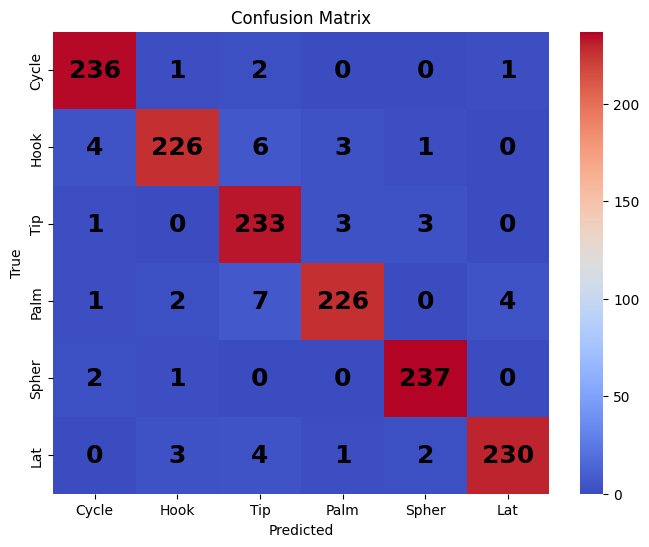

+------------+------------+-----------+-----------+-----------+--------+----------+----------+
| Train Loss | Train Acc. | Test Loss | Test Acc. | Precision | Recall | F1 Score | R2 Score |
+------------+------------+-----------+-----------+-----------+--------+----------+----------+
|   0.0468   |   98.70%   |   0.1483  |   96.39%  |   0.9643  | 0.9639 |  0.9639  |  0.9393  |
+------------+------------+-----------+-----------+-----------+--------+----------+----------+
****************************************************************************************************


Epoch 49/Testing: 100%|██████████| 90/90 [00:00<00:00, 483.87it/s]


+------------+------------+-----------+-----------+-----------+--------+----------+----------+
| Train Loss | Train Acc. | Test Loss | Test Acc. | Precision | Recall | F1 Score | R2 Score |
+------------+------------+-----------+-----------+-----------+--------+----------+----------+
|   0.1122   |   96.90%   |   0.0866  |   97.92%  |   0.9795  | 0.9792 |  0.9792  |  0.9621  |
+------------+------------+-----------+-----------+-----------+--------+----------+----------+
****************************************************************************************************


Epoch 50/Testing: 100%|██████████| 90/90 [00:00<00:00, 447.76it/s]


+------------+------------+-----------+-----------+-----------+--------+----------+----------+
| Train Loss | Train Acc. | Test Loss | Test Acc. | Precision | Recall | F1 Score | R2 Score |
+------------+------------+-----------+-----------+-----------+--------+----------+----------+
|   0.0835   |   97.73%   |   0.0807  |   97.92%  |   0.9793  | 0.9792 |  0.9792  |  0.9624  |
+------------+------------+-----------+-----------+-----------+--------+----------+----------+
****************************************************************************************************


Epoch 51/Testing: 100%|██████████| 90/90 [00:00<00:00, 763.75it/s]


+------------+------------+-----------+-----------+-----------+--------+----------+----------+
| Train Loss | Train Acc. | Test Loss | Test Acc. | Precision | Recall | F1 Score | R2 Score |
+------------+------------+-----------+-----------+-----------+--------+----------+----------+
|   0.0467   |   99.21%   |   0.1074  |   97.01%  |   0.9708  | 0.9701 |  0.9700  |  0.9507  |
+------------+------------+-----------+-----------+-----------+--------+----------+----------+
****************************************************************************************************


Epoch 52/Testing: 100%|██████████| 90/90 [00:00<00:00, 676.69it/s]


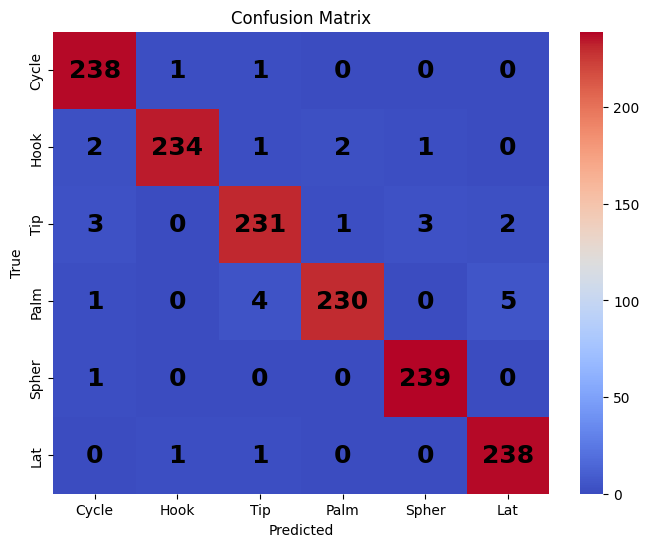

+------------+------------+-----------+-----------+-----------+--------+----------+----------+
| Train Loss | Train Acc. | Test Loss | Test Acc. | Precision | Recall | F1 Score | R2 Score |
+------------+------------+-----------+-----------+-----------+--------+----------+----------+
|   0.0289   |   99.40%   |   0.0810  |   97.92%  |   0.9793  | 0.9792 |  0.9791  |  0.9662  |
+------------+------------+-----------+-----------+-----------+--------+----------+----------+
****************************************************************************************************


Epoch 53/Testing: 100%|██████████| 90/90 [00:00<00:00, 566.04it/s]


+------------+------------+-----------+-----------+-----------+--------+----------+----------+
| Train Loss | Train Acc. | Test Loss | Test Acc. | Precision | Recall | F1 Score | R2 Score |
+------------+------------+-----------+-----------+-----------+--------+----------+----------+
|   0.0284   |   99.54%   |   0.0986  |   97.43%  |   0.9754  | 0.9743 |  0.9745  |  0.9536  |
+------------+------------+-----------+-----------+-----------+--------+----------+----------+
****************************************************************************************************


Epoch 54/Testing: 100%|██████████| 90/90 [00:00<00:00, 687.01it/s]


+------------+------------+-----------+-----------+-----------+--------+----------+----------+
| Train Loss | Train Acc. | Test Loss | Test Acc. | Precision | Recall | F1 Score | R2 Score |
+------------+------------+-----------+-----------+-----------+--------+----------+----------+
|   0.0332   |   99.07%   |   0.1049  |   97.36%  |   0.9749  | 0.9736 |  0.9737  |  0.9593  |
+------------+------------+-----------+-----------+-----------+--------+----------+----------+
****************************************************************************************************


Epoch 55/Testing: 100%|██████████| 90/90 [00:00<00:00, 642.85it/s]


+------------+------------+-----------+-----------+-----------+--------+----------+----------+
| Train Loss | Train Acc. | Test Loss | Test Acc. | Precision | Recall | F1 Score | R2 Score |
+------------+------------+-----------+-----------+-----------+--------+----------+----------+
|   0.0190   |   99.68%   |   0.0724  |   98.33%  |   0.9833  | 0.9833 |  0.9833  |  0.9695  |
+------------+------------+-----------+-----------+-----------+--------+----------+----------+
****************************************************************************************************


Epoch 56/Testing: 100%|██████████| 90/90 [00:00<00:00, 548.77it/s]


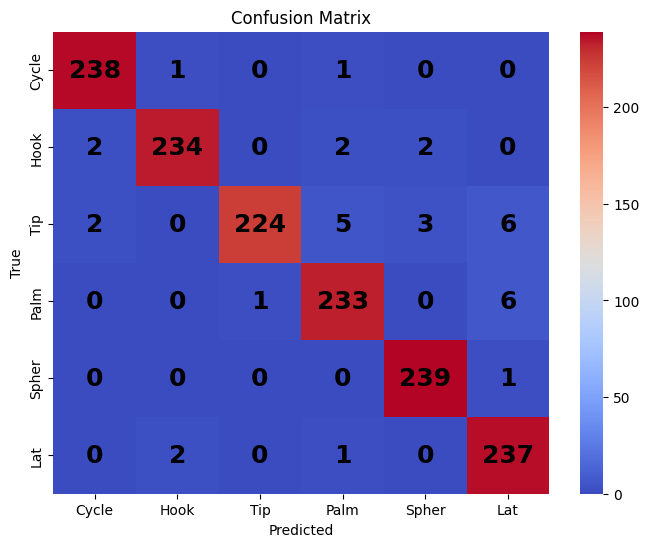

+------------+------------+-----------+-----------+-----------+--------+----------+----------+
| Train Loss | Train Acc. | Test Loss | Test Acc. | Precision | Recall | F1 Score | R2 Score |
+------------+------------+-----------+-----------+-----------+--------+----------+----------+
|   0.0152   |   99.68%   |   0.0932  |   97.57%  |   0.9761  | 0.9757 |  0.9756  |  0.9574  |
+------------+------------+-----------+-----------+-----------+--------+----------+----------+
****************************************************************************************************


Epoch 57/Testing: 100%|██████████| 90/90 [00:00<00:00, 638.29it/s]


+------------+------------+-----------+-----------+-----------+--------+----------+----------+
| Train Loss | Train Acc. | Test Loss | Test Acc. | Precision | Recall | F1 Score | R2 Score |
+------------+------------+-----------+-----------+-----------+--------+----------+----------+
|   0.0946   |   97.50%   |   0.0378  |   99.24%  |   0.9924  | 0.9924 |  0.9924  |  0.9886  |
+------------+------------+-----------+-----------+-----------+--------+----------+----------+
****************************************************************************************************


Epoch 58/Testing: 100%|██████████| 90/90 [00:00<00:00, 725.82it/s]


+------------+------------+-----------+-----------+-----------+--------+----------+----------+
| Train Loss | Train Acc. | Test Loss | Test Acc. | Precision | Recall | F1 Score | R2 Score |
+------------+------------+-----------+-----------+-----------+--------+----------+----------+
|   0.0504   |   98.70%   |   0.0412  |   99.10%  |   0.9911  | 0.9910 |  0.9909  |  0.9845  |
+------------+------------+-----------+-----------+-----------+--------+----------+----------+
****************************************************************************************************


Epoch 59/Testing: 100%|██████████| 90/90 [00:00<00:00, 629.38it/s]


+------------+------------+-----------+-----------+-----------+--------+----------+----------+
| Train Loss | Train Acc. | Test Loss | Test Acc. | Precision | Recall | F1 Score | R2 Score |
+------------+------------+-----------+-----------+-----------+--------+----------+----------+
|   0.0258   |   99.35%   |   0.0449  |   99.10%  |   0.9911  | 0.9910 |  0.9910  |  0.9867  |
+------------+------------+-----------+-----------+-----------+--------+----------+----------+
****************************************************************************************************


Epoch 60/Testing: 100%|██████████| 90/90 [00:00<00:00, 647.48it/s]


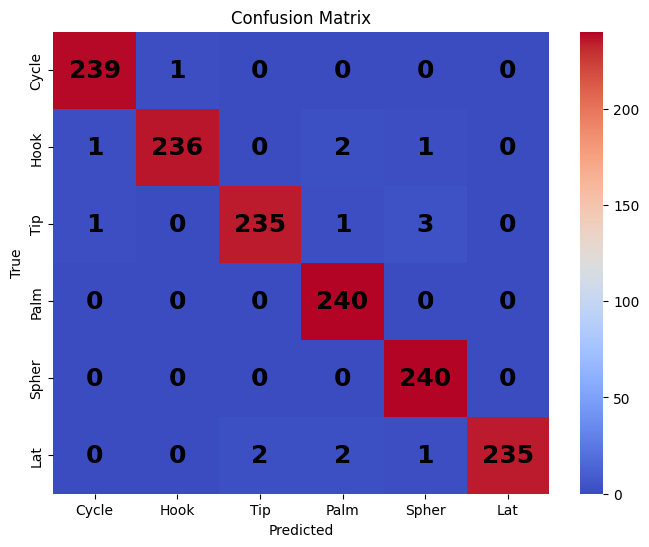

+------------+------------+-----------+-----------+-----------+--------+----------+----------+
| Train Loss | Train Acc. | Test Loss | Test Acc. | Precision | Recall | F1 Score | R2 Score |
+------------+------------+-----------+-----------+-----------+--------+----------+----------+
|   0.0227   |   99.49%   |   0.0454  |   98.96%  |   0.9897  | 0.9896 |  0.9896  |  0.9850  |
+------------+------------+-----------+-----------+-----------+--------+----------+----------+
****************************************************************************************************


Epoch 61/Testing: 100%|██████████| 90/90 [00:00<00:00, 588.24it/s]


+------------+------------+-----------+-----------+-----------+--------+----------+----------+
| Train Loss | Train Acc. | Test Loss | Test Acc. | Precision | Recall | F1 Score | R2 Score |
+------------+------------+-----------+-----------+-----------+--------+----------+----------+
|   0.0173   |   99.63%   |   0.0371  |   99.03%  |   0.9904  | 0.9903 |  0.9903  |  0.9771  |
+------------+------------+-----------+-----------+-----------+--------+----------+----------+
****************************************************************************************************


Epoch 62/Testing: 100%|██████████| 90/90 [00:00<00:00, 681.82it/s]


+------------+------------+-----------+-----------+-----------+--------+----------+----------+
| Train Loss | Train Acc. | Test Loss | Test Acc. | Precision | Recall | F1 Score | R2 Score |
+------------+------------+-----------+-----------+-----------+--------+----------+----------+
|   0.0106   |   99.86%   |   0.0373  |   99.03%  |   0.9904  | 0.9903 |  0.9903  |  0.9771  |
+------------+------------+-----------+-----------+-----------+--------+----------+----------+
****************************************************************************************************


Epoch 63/Testing: 100%|██████████| 90/90 [00:00<00:00, 737.72it/s]


+------------+------------+-----------+-----------+-----------+--------+----------+----------+
| Train Loss | Train Acc. | Test Loss | Test Acc. | Precision | Recall | F1 Score | R2 Score |
+------------+------------+-----------+-----------+-----------+--------+----------+----------+
|   0.0099   |   99.95%   |   0.0402  |   99.17%  |   0.9917  | 0.9917 |  0.9917  |  0.9852  |
+------------+------------+-----------+-----------+-----------+--------+----------+----------+
****************************************************************************************************


Epoch 64/Testing: 100%|██████████| 90/90 [00:00<00:00, 601.92it/s]


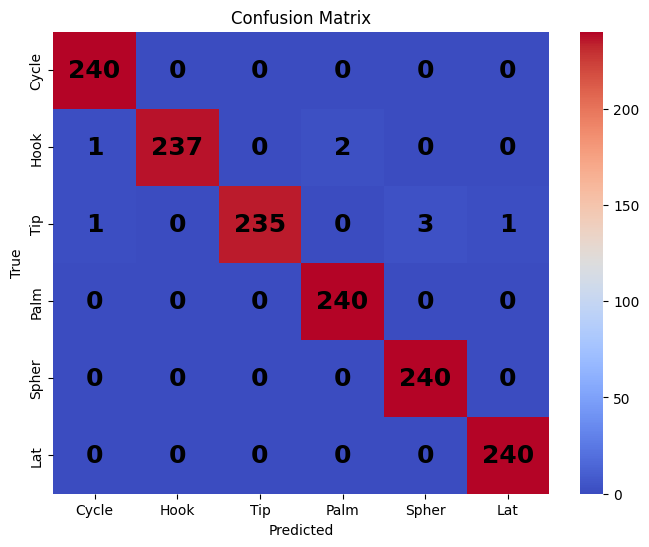

+------------+------------+-----------+-----------+-----------+--------+----------+----------+
| Train Loss | Train Acc. | Test Loss | Test Acc. | Precision | Recall | F1 Score | R2 Score |
+------------+------------+-----------+-----------+-----------+--------+----------+----------+
|   0.0111   |   99.81%   |   0.0380  |   99.44%  |   0.9945  | 0.9944 |  0.9944  |  0.9919  |
+------------+------------+-----------+-----------+-----------+--------+----------+----------+
****************************************************************************************************


In [57]:
train_losses = []    # To store training losses for each epoch
train_accuracies = []    # To store training accuracies for each epoch
val_losses = []    # To store testing losses for each epoch
val_accuracies = []    # To store testing accuracies for each epoch
precisions = []    # To store precision scores for each epoch
recalls = []    # To store recall scores for each epoch
f1_scores = []    # To store F1 scores for each epoch
r2_scores = []    # To store R2 scores for each epoch

kfold=8
num_epochs = 8
skf= StratifiedShuffleSplit(n_splits=kfold, random_state=42,test_size=0.4)
fold_idx = -1
for train_idx, val_idx in skf.split(X, y):
    fold_idx+=1
    # Split the data into training and validation sets for the current fold
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]
    # X_train=X_train.to_numpy()
    # X_val=X_val.to_numpy()
    # y_train=y_train.to_numpy()
    # y_val=y_val.to_numpy()

    # CustomDataset sınıfını kullanarak DataLoader'ları oluşturun
    train_dataset = CustomDataset(X_train, y_train)
    val_dataset = CustomDataset(X_val, y_val)

    # DataLoader'ları ayarlayın
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)  
    for epoch in range(num_epochs):
        # Training phase
        train_loss, train_accuracy = train(model, train_loader, criterion, optimizer, fold_idx*8+epoch)
        
        # Evaluation phase on the test set
        val_loss, val_acc, precision, recall, f1, r2 = evaluate(model, val_loader, criterion, fold_idx*8+epoch)

        # Append the results to the corresponding lists
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1)
        r2_scores.append(r2)

        torch.save(model.state_dict(), "last.pth")
        # chcek improvement
        if val_loss < best_loss:
            best_loss = val_loss
            torch.save(model.state_dict(), "best.pth")

        
        # Create a PrettyTable
        results_table = PrettyTable()
        results_table.field_names = ["Train Loss", "Train Acc.","Test Loss","Test Acc.","Precision","Recall","F1 Score","R2 Score"]

        # Add metrics to the PrettyTable
        c1=f"{train_loss:.4f}"
        c2=f"{train_accuracy * 100:.2f}%"
        c3=f"{val_loss:.4f}"
        c4=f"{val_acc * 100:.2f}%"
        c5=f"{precision:.4f}"
        c6=f"{recall:.4f}"
        c7=f"{f1:.4f}"
        c8=f"{r2:.4f}"
        results_table.add_row([c1,c2,c3,c4,c5,c6,c7,c8])

        # Print the PrettyTable
        print(results_table)

        print("*" * 100)

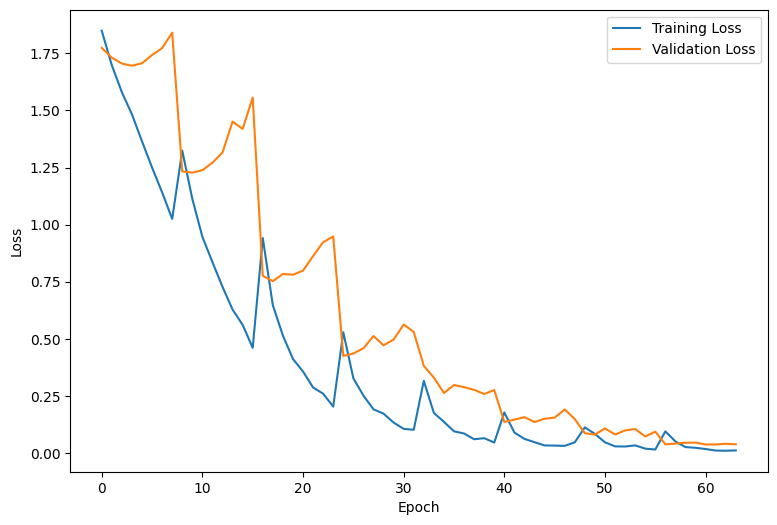

In [58]:
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

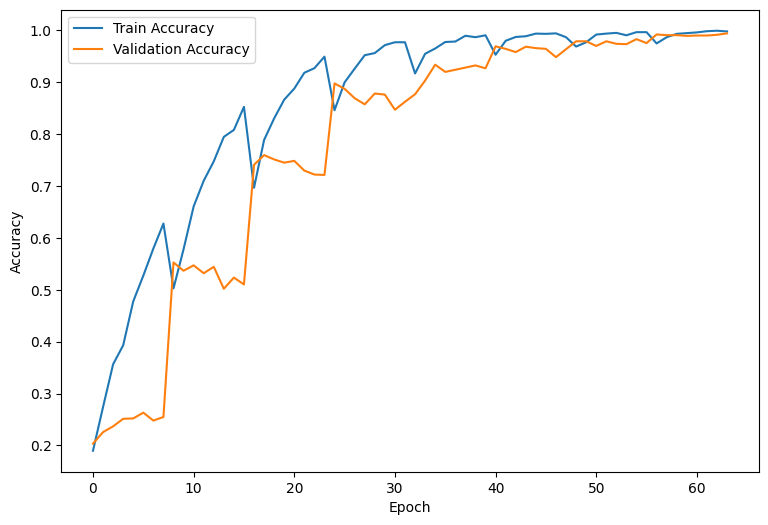

In [59]:
plt.plot(train_accuracies,label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

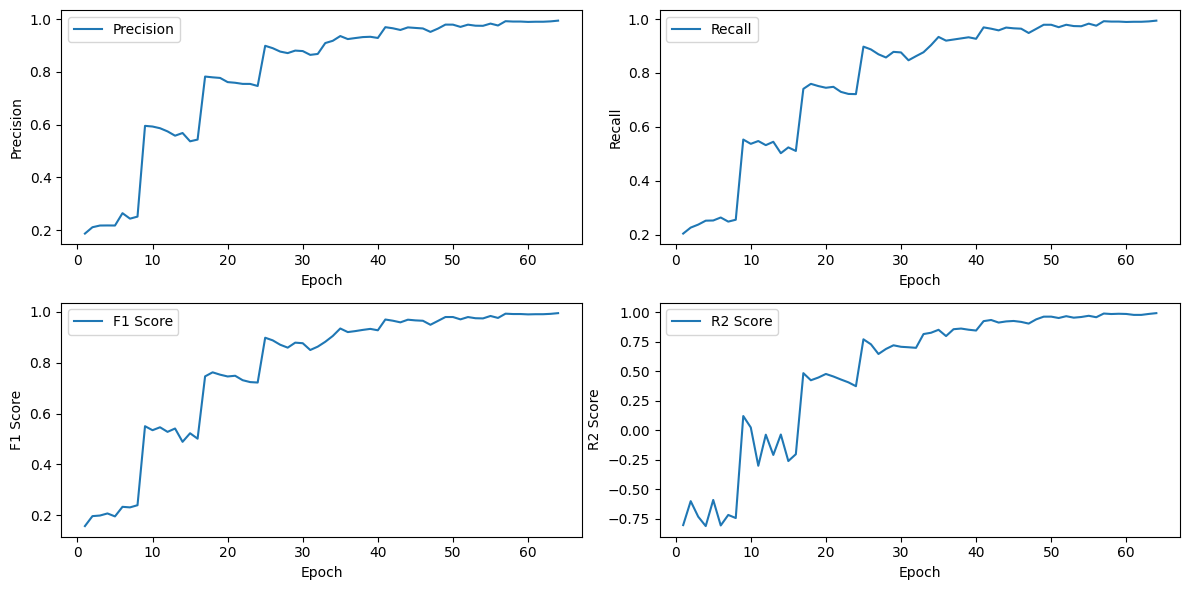

In [60]:
epochs = range(1, kfold*num_epochs + 1)

plt.figure(figsize=(12, 6))
plt.subplot(2, 2, 1)
plt.plot(epochs, precisions, label='Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(epochs, recalls, label='Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(epochs, f1_scores, label='F1 Score')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(epochs, r2_scores, label='R2 Score')
plt.xlabel('Epoch')
plt.ylabel('R2 Score')
plt.legend()

plt.tight_layout()